In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import nbinom
from tqdm.notebook import trange, tqdm
import seaborn as sns 
import pandas as pd
import scipy.stats as stats

%matplotlib notebook

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Helvetica"]})

plt.rc('xtick', labelsize = 18)
plt.rc('ytick', labelsize = 18)

colors = plt.cm.viridis(np.linspace(0.1, 1, 10))

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Clone populations traces

In [2]:
def trajectories_initial(A,B, N_int, N_traj):
    
    tvec = np.linspace(0,5,10000)
    dt = tvec[1]-tvec[0]
    N_ext = 1
    
    x_int = np.log(N_int)
    x = x_int*np.ones((N_traj, len(tvec) ))
    for i in tqdm(range((len(tvec)-1))):
        x_1D = x[:, i]
        x_1D[x_1D<= np.log(N_ext)] = -np.inf
        x[:, i] = x_1D
        
        x[:, i+1] = x[:, i] + A*(dt) + np.sqrt(B*dt)*np.random.randn(N_traj)
         
    return x

In [3]:
A,B, N_int, N_traj = -0.5, 0.9, 40, 1000
x_1 = trajectories_initial(A,B, N_int, N_traj)

In [4]:
tvec = np.linspace(0,5,10000)
y = np.log(N_int) + A*tvec
theta_func_plus = y + np.sqrt(B*tvec)
theta_func_moins = y - np.sqrt(B*tvec)

## Cumulative distributions from synthetic data 

In [5]:
def cumulative_distributions(df, Clone_fraction):
    
    df_true = df[df[Clone_fraction] != 0]
    df_true_new = df_true.copy()
    df_true_new['Id'] = 1
    distribution = df_true_new.groupby([Clone_fraction])['Id'].sum()
    distribution = distribution.values
    frequencies = df_true_new[Clone_fraction].unique()
    frequencies = sorted(frequencies)
    
    x_Patient = np.log(frequencies)
    y_Patient = np.log(np.max(np.cumsum(distribution)) - np.cumsum(distribution))
    
    #print(x_Patient[:-1])
    #print(distribution)
    
    slope_Patient, intercept_Patient, r_value_Patient, p_value_Patient, std_err_Patient = stats.linregress(x_Patient[:-1], y_Patient[:-1])
    Y_Patient = intercept_Patient + slope_Patient*np.array(x_Patient)
    
    
    return frequencies, x_Patient, y_Patient, slope_Patient, intercept_Patient, Y_Patient

In [6]:
df_2 = pd.read_csv('LB_synthetic_sym_NegBin_N0_40_A_-0.5_B_0.9_2_years_0.csv', sep = '\t')
df_3 = pd.read_csv('LB_synthetic_sym_NegBin_N0_40_A_-0.5_B_0.8_2_years_0.csv', sep = '\t')
df_4 = pd.read_csv('LB_synthetic_sym_NegBin_N0_40_A_-0.5_B_0.85_2_years_0.csv', sep = '\t')

In [7]:
frequencies_1_05, x_1_05, y_1_05, slope_1_05, intercept_1_05, Y_1_05 = cumulative_distributions(df_2, 'Clone_frequency_1')
frequencies_1_05_bis, x_1_05_bis, y_1_05_bis, slope_1_05_bis, intercept_1_05_bis, Y_1_05_bis = cumulative_distributions(df_3, 'Clone_frequency_1')
frequencies_1_05_ter, x_1_05_ter, y_1_05_ter, slope_1_05_ter, intercept_1_05_ter, Y_1_05_ter = cumulative_distributions(df_4, 'Clone_frequency_1')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


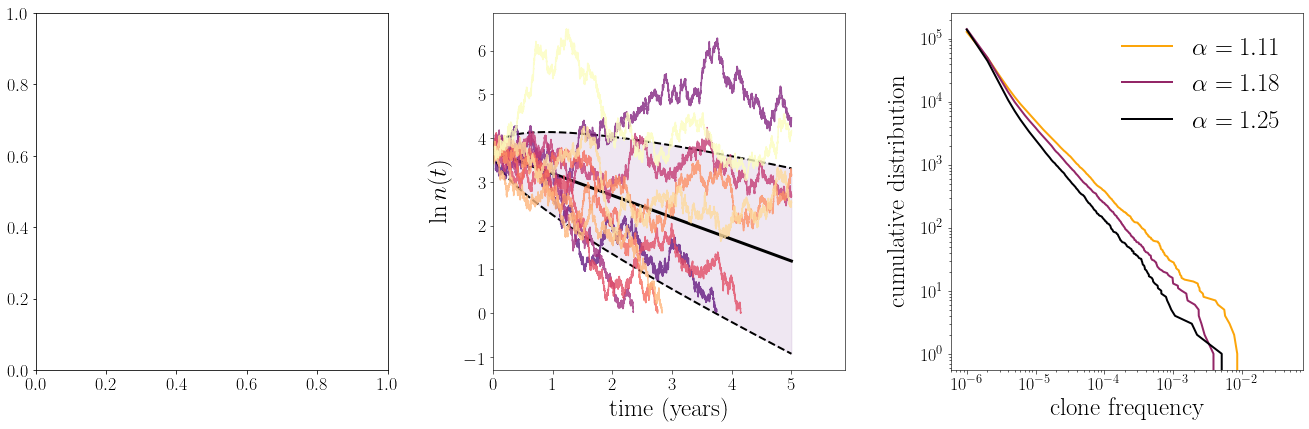

In [8]:
fig, ((ax1,ax2,ax3)) = plt.subplots(1,3,figsize=(22,6.2))
plt.rc('text', usetex=True)


# Subplot 2

colors = plt.cm.magma(np.linspace(0.3, 1, 10))

ax2.plot(tvec, y, color = 'k', linewidth = 3)
ax2.plot(tvec, theta_func_moins, color = 'k', linestyle = '--', linewidth = 2)
ax2.plot(tvec, theta_func_plus, color = 'k', linestyle = '--', linewidth = 2)
ax2.fill_between(tvec, theta_func_moins, theta_func_plus, color =colors[0], alpha = 0.1 )
#plt.yaxis.set_tick_params(width=.8)

for i in range(10):
    
    ax2.plot(tvec, x_1[i, :], color = colors[i], alpha = 0.8)

ax2.axis([0,5.9, None, None])

ax2.set_xlabel('time (years)', fontsize = 25)
ax2.set_ylabel('$ \ln n(t)$',labelpad=12, fontsize = 25)


ax2.xaxis.set_tick_params(width=.6)
ax2.yaxis.set_tick_params(width=.6)
plt.setp(ax2.spines.values(), linewidth=.6)

# Subplot 3
colors = plt.cm.inferno_r(np.linspace(0.2, 1, 3))
ax3.plot(frequencies_1_05, np.exp(y_1_05), color= colors[0], linewidth = 2,  label = r'$ \alpha =1.11$')
ax3.plot(frequencies_1_05_ter, np.exp(y_1_05_ter), color= colors[1], linewidth = 2, label = r'$ \alpha =1.18 $')
ax3.plot(frequencies_1_05_bis, np.exp(y_1_05_bis), color= colors[2], linewidth = 2, label = r'$ \alpha =1.25 $')

ax3.legend(fontsize=25, frameon = False)

ax3.set_xscale('log')
ax3.set_yscale('log')

ax3.xaxis.set_tick_params(width=.6)
ax3.yaxis.set_tick_params(width=.6)
ax3.set_xlabel('clone frequency', fontsize = 25)
ax3.set_ylabel('cumulative distribution',labelpad=12, fontsize = 25)


plt.setp(ax3.spines.values(), linewidth=.6)



# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)

#fig.savefig('/Users/bensouda/Documents/PhD/Codes_figures/Fig2.pdf', bbox_inches='tight')

plt.show()